In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import chromATAC as ca
from chromATAC.integrated import IntData
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
from tqdm import tqdm
import warnings
import seaborn as sns

warnings.simplefilter("ignore", category=pd.errors.ParserWarning)

In [3]:
def get_gaps(df):
    # Ensure the DataFrame is sorted
    df_sorted = df.sort_values(by=['chr', 'start'])

    # Prepare the list to store gap regions
    gaps = []

    # Iterate over the DataFrame
    for chrom, group in df_sorted.groupby('chr'):
        prev_end = None
        for _, row in group.iterrows():
            if prev_end is not None and prev_end < row['start']:
                # Found a gap
                gaps.append([chrom, prev_end, row['start']])
            prev_end = row['end']

    # Create a DataFrame for gaps
    gaps_df = pd.DataFrame(gaps, columns=['chr', 'start', 'end'])
    return gaps_df

In [4]:
parent_dir = '/Users/mossishahi/Code/lupien/IntData'

In [7]:
tes_dir = parent_dir+'/data/V2-TEs/non_olap'
cotes_dir = parent_dir+'/data/V2-TEs/cores1000/'

In [8]:
TEs = np.array([i.split('.')[0] for i in os.listdir(tes_dir) if i.endswith('.bed')])
COTEs = np.array([i.split('.')[0] for i in os.listdir(cotes_dir) if i.endswith('.bed')])

In [9]:
te_meta = pd.read_csv(parent_dir+'/analysis/data/repeat_metadata.onlyTEs_full.tsv', sep='\t')
te_df = te_meta.iloc[np.concatenate([np.where(te_meta['repname_numbered'].apply(lambda x: i.split('_')[0]==x.split('_')[0]))[0] for i in TEs]), :].loc[:, ['repname', 'Superfamily', 'repname_numbered']].copy()
te_df.index = range(1, len(te_df)+1)
te_df['COTE'] = te_df['repname_numbered'].apply(lambda x: x.split('_')[0] in np.array([i.split('_')[0] for i in np.intersect1d(TEs, COTEs)]))
te_df.loc[971] = ['ERV3-16A3_I-int', 'ERVL', '369_ERV3-16A3_I-int', True]

In [13]:
te_n_elements = pd.read_csv(tes_dir+'/n_elements_per_TE.tsv', sep='\t', header=None, names = ['name', 'n_elements'])
cote_n_elments = pd.read_csv(cotes_dir+'/n_clusters_per_TE.tsv', sep='\t', header=None, names = ['name', 'n_clusters'])

In [14]:
te_n_elements['name'] = te_n_elements['name'].apply(lambda x: x.split('_Merged.bed')[0])
cote_n_elments['name'] = cote_n_elments['name'].apply(lambda x: x.split('_Merged.bed')[0])
te_df = te_df.merge(te_n_elements, how='left', left_on='repname_numbered', right_on='name').merge(cote_n_elments, how='left', left_on='repname_numbered', right_on='name').drop(['name_x', 'name_y'], axis=1).fillna(0)
te_df.set_index('repname_numbered', inplace=True)

In [15]:
for t in TEs:
    df = pd.read_csv(str(os.path.join(tes_dir,t))+ '.bed', sep='\t', names=['chr', 'start', 'end', 'value'])
    df['length']=df['end']-df['start']
    te_df.loc[pd.Series(te_df.index).apply(lambda x: x in t.split('_Merged')[0]).values,'mean_length']=df['length'].mean()

In [16]:
cote_df = te_df[te_df.COTE].copy()

In [17]:
for t in COTEs:
    df = pd.read_csv(str(os.path.join(cotes_dir,t))+ '.bed', sep='\t', names=['chr', 'start', 'end', 'value'])
    df['length'] = df['end']-df['start']
    cote_df.loc[pd.Series(cote_df.index).apply(lambda x: x in t.split('_Merged')[0]).values,'mean_length']=df['length'].mean()

In [18]:
for t in TEs:
    df = pd.read_csv(str(os.path.join(tes_dir,t))+ '.bed', sep='\t', names=['chr', 'start', 'end', 'value'])
    df = get_gaps(df)
    df['length']=df['end']-df['start']
    te_df.loc[pd.Series(te_df.index).apply(lambda x: x in t.split('_Merged')[0]).values,'mean_dist_length']=df['length'].mean()

In [19]:
for t in COTEs:
    df = pd.read_csv(str(os.path.join(cotes_dir,t))+ '.bed', sep='\t', names=['chr', 'start', 'end', 'value'])
    df = get_gaps(df)
    df['length']=df['end']-df['start']
    cote_df.loc[pd.Series(cote_df.index).apply(lambda x: x in t.split('_Merged')[0]).values,'mean_CoTEs_dist_length']=df['length'].mean()

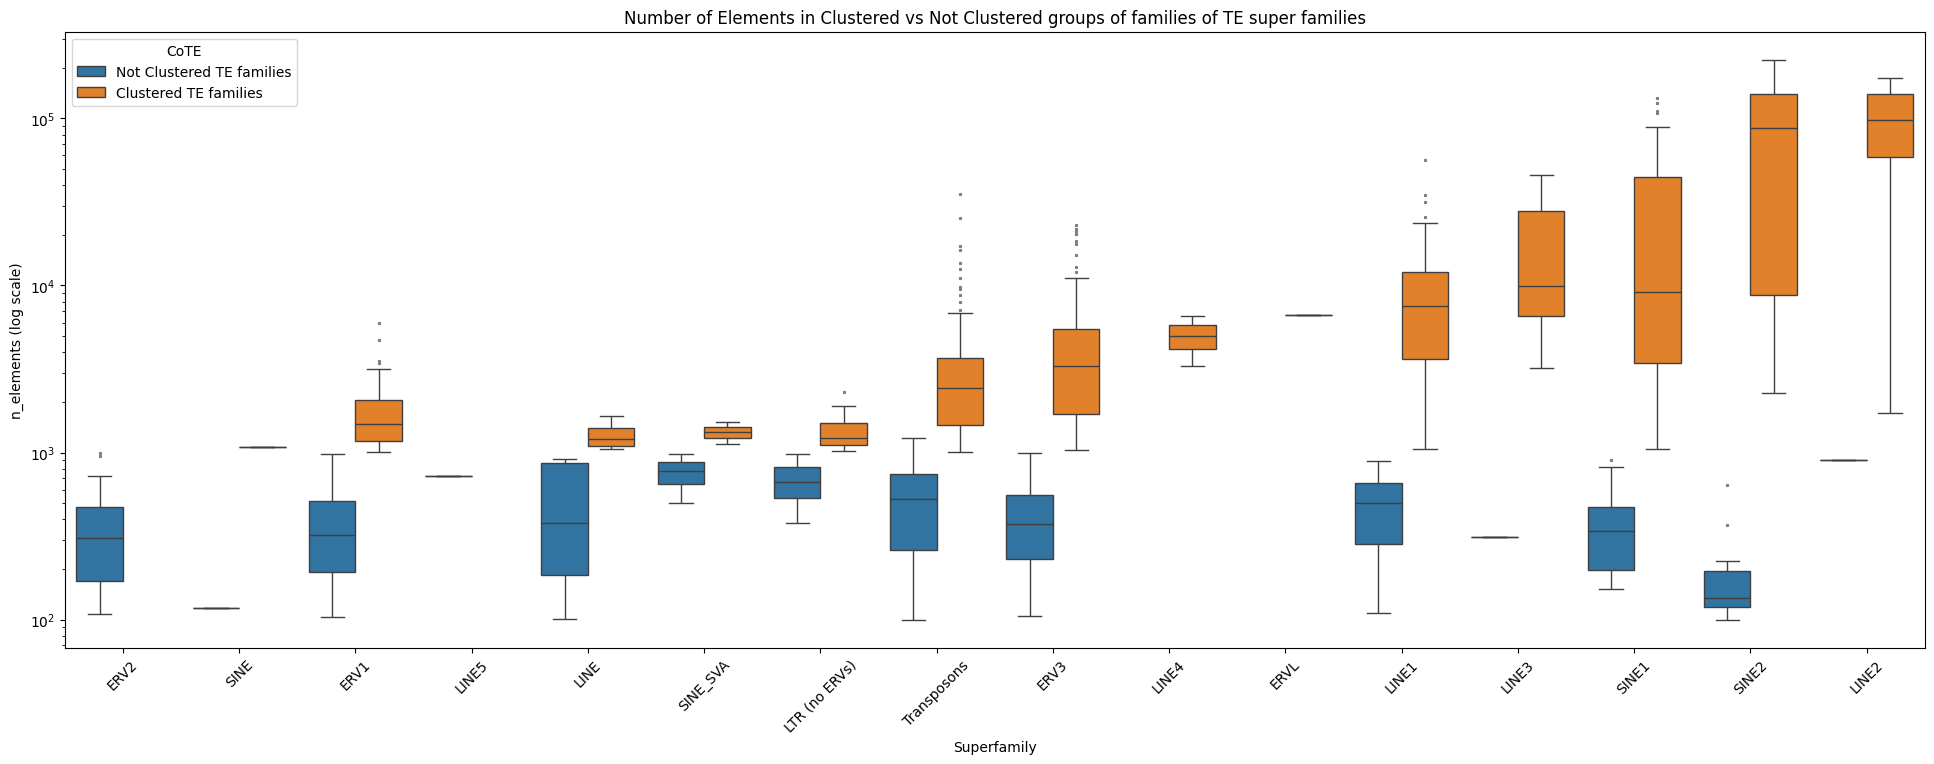

In [184]:
# Calculating mean values for sorting 'n_elements'
mean_n_elements = te_df.groupby('Superfamily')['n_elements'].mean().sort_values()
sorted_superfamilies_by_mean_n_elements = mean_n_elements.index

# Creating sorted grouped boxplots for 'n_elements' based on mean values
plt.figure(figsize=(24, 8))
# sns.stripplot(x='Superfamily', y='n_elements', hue='COTE', data=te_df, order=sorted_superfamilies_by_mean_n_elements)#, fliersize=2, flierprops=dict(marker='*', color='grey', markeredgecolor='grey')) 
sns.boxplot(x='Superfamily', y='n_elements', hue='COTE', data=te_df, order=sorted_superfamilies_by_mean_n_elements, fliersize=2, flierprops=dict(marker='*', color='grey', markeredgecolor='grey')) 
plt.yscale('log')
plt.title('Number of Elements in Clustered vs Not Clustered groups of families of TE super families')
plt.xlabel('Superfamily')
plt.ylabel('n_elements (log scale)')
plt.xticks(rotation=45)
handles, labels = plt.gca().get_legend_handles_labels()

# Define your new labels
new_labels = ['Not Clustered TE families', 'Clustered TE families']  # Update these as necessary
# Create new legend
plt.legend(handles=handles, labels=new_labels, title='CoTE')
plt.savefig('bx_cote_not.png')
plt.show()

<Figure size 1000x600 with 0 Axes>

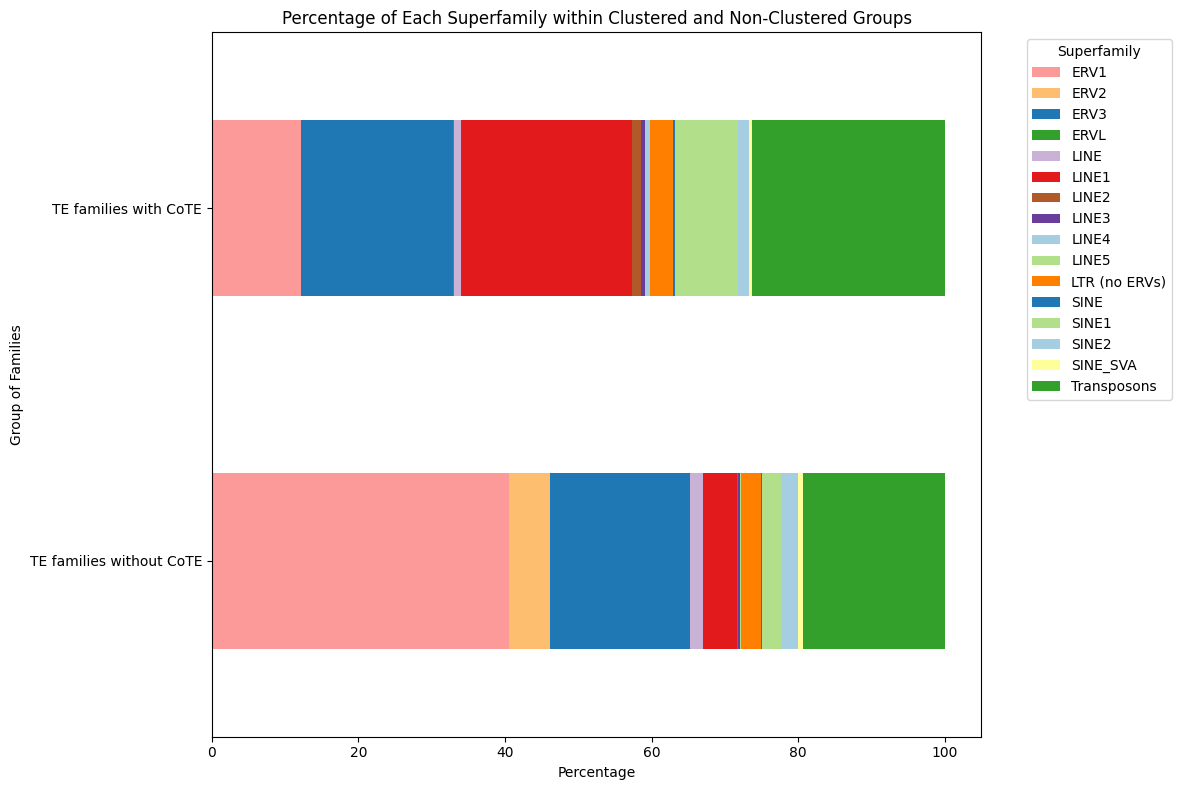

In [185]:
# Create a distinct color palette

unique_superfamilies = te_df['Superfamily'].unique()
colors = sns.color_palette("Paired", len(unique_superfamilies))
color_dict = dict(zip(unique_superfamilies, colors))
superfamily_counts = te_df.groupby(['COTE', 'Superfamily']).size().unstack(fill_value=0)
superfamily_percentages = superfamily_counts.div(superfamily_counts.sum(axis=1), axis=0) * 100

# Create a stacked horizontal bar plot with distinct colors for each superfamily
fig=plt.figure(figsize=(10, 6))
superfamily_percentages.plot(kind='barh', stacked=True, figsize=(12, 8), color=[color_dict[x] for x in superfamily_percentages.columns])
plt.title('Percentage of Each Superfamily within Clustered and Non-Clustered Groups')
plt.xlabel('Percentage')
plt.ylabel('Group of Families')
plt.legend(title='Superfamily', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yticks(ticks=[0, 1], labels=['TE families without CoTE', 'TE families with CoTE'])
plt.tight_layout()
plt.savefig('sp_fam_n_elements.png', dpi=600)
plt.show()

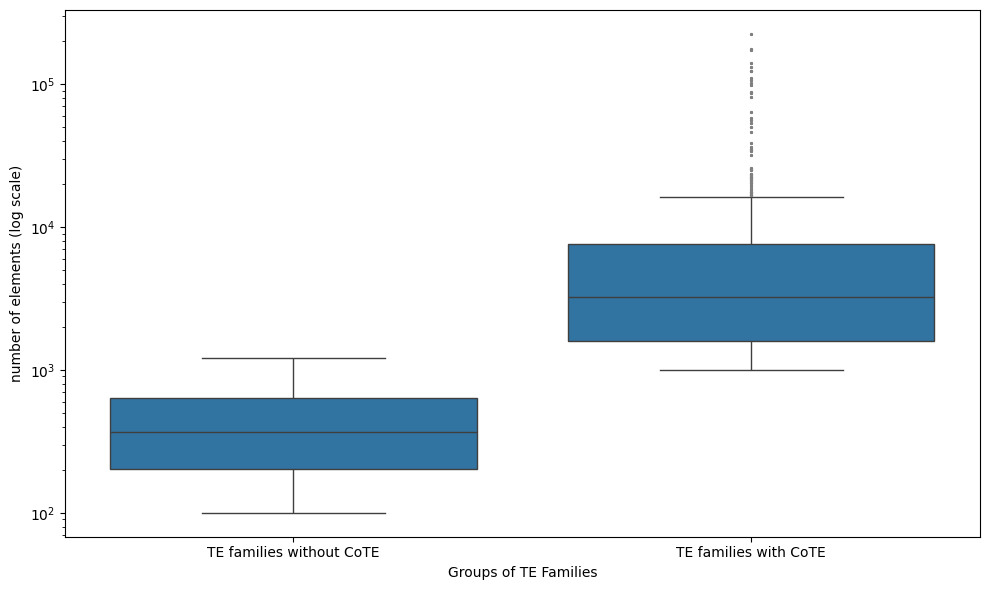

In [64]:
fig=plt.figure(figsize=(10, 6))
sns.boxplot(x=te_df['COTE'], y=te_df['n_elements'], showfliers=True, fliersize=2, flierprops=dict(marker='*', color='grey', markeredgecolor='grey'))  # Custom flier color)
plt.yscale('log')
plt.xlabel('Groups of TE Families')
plt.xticks(ticks=[0, 1], labels=['TE families without CoTE', 'TE families with CoTE'])
plt.ylabel('number of elements (log scale)')
plt.tight_layout()
plt.show()
fig.savefig('n_elements.png', dpi=600)

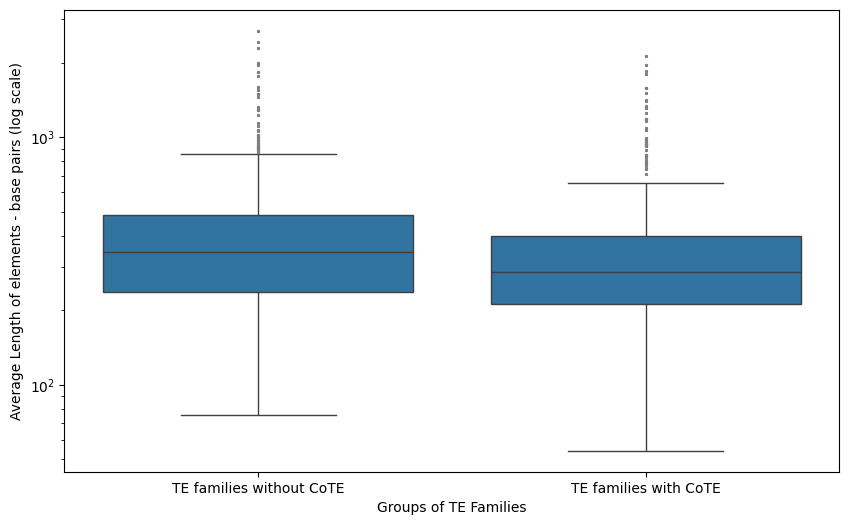

In [68]:
fig=plt.figure(figsize=(10, 6))
sns.boxplot(x=te_df['COTE'], y=te_df['mean_length'], showfliers=True, fliersize=2, flierprops=dict(marker='*', color='grey', markeredgecolor='grey'))  # Custom flier color)
plt.yscale('log')
plt.xlabel('Groups of TE Families')
plt.xticks(ticks=[0, 1], labels=['TE families without CoTE', 'TE families with CoTE'])
plt.ylabel('Average Length of elements - base pairs (log scale)')
plt.show()
fig.savefig('len_elements.png', dpi=600)

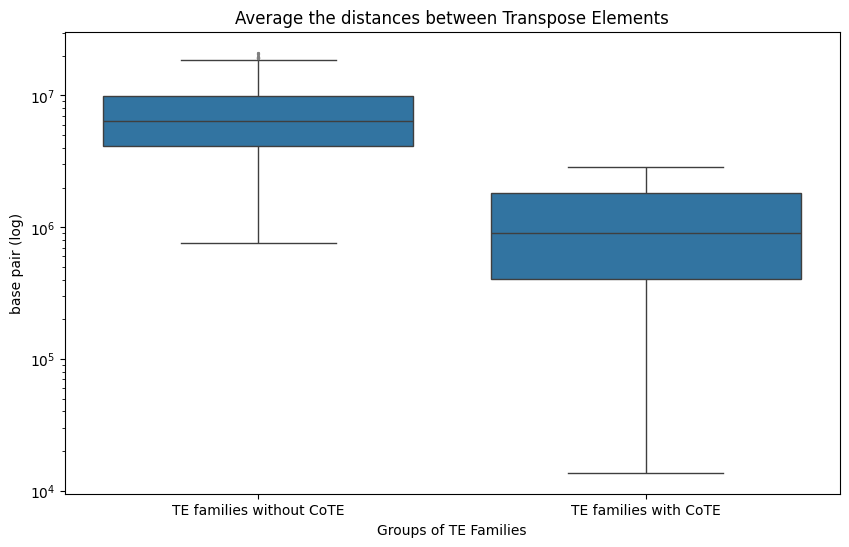

In [69]:
fig=plt.figure(figsize=(10, 6))
sns.boxplot(x=te_df['COTE'], y=te_df['mean_dist_length'], showfliers=True, fliersize=2, flierprops=dict(marker='*', color='grey', markeredgecolor='grey'))  # Custom flier color)
plt.title('Average the distances between Transpose Elements')
plt.yscale('log')
plt.xlabel('Groups of TE Families')
plt.xticks(ticks=[0, 1], labels=['TE families without CoTE', 'TE families with CoTE'])
plt.ylabel('base pair (log)')
plt.show()
fig.savefig('mean_dist_elements.png', dpi=600)

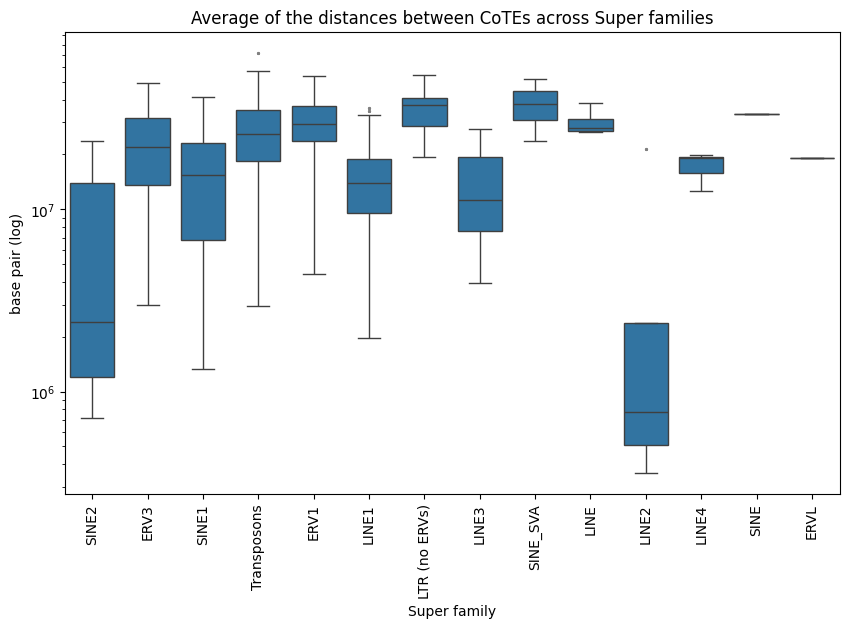

In [57]:
fig=plt.figure(figsize=(10, 6))
sns.boxplot(x=cote_df['Superfamily'], y=cote_df['mean_CoTEs_dist_length'], showfliers=True, fliersize=2, flierprops=dict(marker='*', color='grey', markeredgecolor='grey'))  # Custom flier color)
plt.yscale('log')
plt.title('Average of the distances between CoTEs across Super families')
plt.xlabel('Super family')
plt.xticks(rotation=90)
plt.ylabel('base pair (log)')
plt.show()
fig.savefig('dist_CoTEs_supers.png', dpi=600)

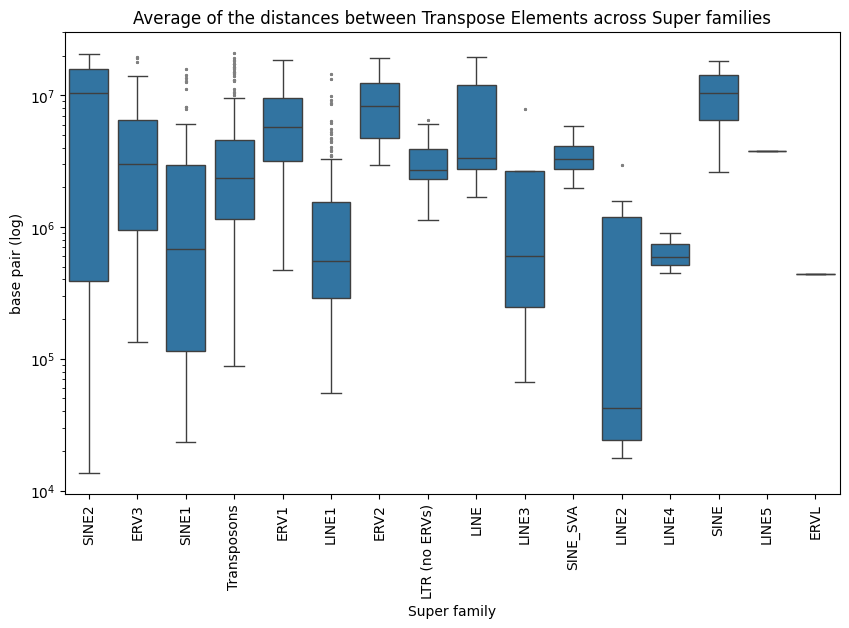

In [58]:
fig=plt.figure(figsize=(10, 6))
sns.boxplot(x=te_df['Superfamily'], y=te_df['mean_dist_length'], showfliers=True, fliersize=2, flierprops=dict(marker='*', color='grey', markeredgecolor='grey'))  # Custom flier color)
plt.title('Average of the distances between Transpose Elements across Super families')
plt.yscale('log')
plt.xlabel('Super family')
plt.xticks(rotation=90)
plt.ylabel('base pair (log)')
plt.show()
fig.savefig('dist_elements_supers.png', dpi=600)

In [25]:
ctes = []
for f in COTEs:
    df = pd.read_csv(cotes_dir+'/'+f+'.bed', sep='\t', names=['chr', 'start', 'end'], index_col=False)
    cdf = df.groupby('chr').count()
    cdf.rename(columns={'start': f.split('_Merged')[0]}, inplace=True)
    cdf = cdf.T.loc[:, [i for i in cdf.T.columns if i in ca.info.CHROMOSOMES['names']]].iloc[0,:].T
    ctes.append(cdf)

_ctes = pd.concat(ctes, axis=1).T.fillna(0)
__ctes = _ctes.div(_ctes.sum(1), axis=0).fillna(0)
_ctes = _ctes.join(te_df)
df_ct = _ctes.groupby(['Superfamily']).sum()
df_ct = df_ct.sort_index(axis=0).sort_index(axis=1)
df_ct = df_ct.loc[:, [i for i in df_ct.columns if 'chr' in i]]
ct_row_sums = df_ct.sum(axis=1)
df_ct_percentage = df_ct.div(ct_row_sums, axis=0) * 100
df_ct_percentage.fillna(0, inplace=True)

In [23]:
tes = []
for f in TEs:
    df = pd.read_csv(tes_dir+'/'+f+'.bed', sep='\t', names=['chr', 'start', 'end'], index_col=False)
    cdf = df.groupby('chr').count()
    cdf.rename(columns={'start': f.split('_Merged')[0]}, inplace=True)
    cdf = cdf.T.loc[:, [i for i in cdf.T.columns if i in ca.info.CHROMOSOMES['names']]].iloc[0,:].T
    tes.append(cdf)

_tes = pd.concat(tes, axis=1).T.fillna(0)
__tes = _tes.div(_tes.sum(1), axis=0).fillna(0)
_tes = _tes.join(te_df)
df_t = _tes.groupby(['Superfamily']).sum().sort_index(axis=0).sort_index(axis=1)
df_t = df_t.sort_index(axis=0).sort_index(axis=1)
df_t = df_t.loc[:, [i for i in df_t.columns if 'chr' in i]]
te_row_sums = df_t.sum(axis=1)
df_t_percentage = df_t.div(te_row_sums, axis=0) * 100
df_t_percentage.fillna(0, inplace=True)

In [51]:
def plot_te_family_distribution(df1, df2, te_family_name):
    """
    Plots the distribution of a specified TE family across all chromosomes
    in two given dataframes.

    :param df1: First dataframe.
    :param df2: Second dataframe.
    :param te_family_name: Part of the name of the TE family to search for.
    """

    # Find the row index in each dataframe that contains the specified TE family name
    index_df1 = [i for i in df1.index if te_family_name in str(i)]
    index_df2 = [i for i in df2.index if te_family_name in str(i)]

    # Check if the TE family is found in both dataframes
    if not index_df1 or not index_df2:
        print("TE family not found in one or both dataframes.")
        return

    # Extract the rows for the specified TE family
    te_family_df1 = df1.loc[index_df1]
    te_family_df2 = df2.loc[index_df2]

    bar_width = 0.35

    # Plotting the distributions
    fig = plt.figure(figsize=(18, 8 * len(index_df1)))

    for idx, (index_1, index_2) in enumerate(zip(index_df1, index_df2)):
        positions = range(len(te_family_df1.columns))
        legend_text2 = 'CoTEs'
        legend_text1 = 'TEs'
        plt.subplot(len(index_df1), 1, idx + 1)
        plt.bar([p - bar_width/2 for p in positions], te_family_df1.loc[index_1].values, bar_width, label=legend_text1)
        plt.bar([p + bar_width/2 for p in positions], te_family_df2.loc[index_2].values, bar_width, label=legend_text2)
        plt.title(f'Distribution of TEs vs CoTEs from Family "{te_family_name.split('_')[-1]}" Across genome', fontsize=22)
        plt.xlabel('Chromosome')
        plt.ylabel('Percentage of Total')
        plt.xticks(positions, te_family_df1.columns, rotation=45)
        plt.legend()

    plt.tight_layout()
    plt.show()
    return fig
# Example usage of the function
# plot_te_family_distribution(tes_df, ctes_df, "542_L1MA1")  # Uncomment to use the function

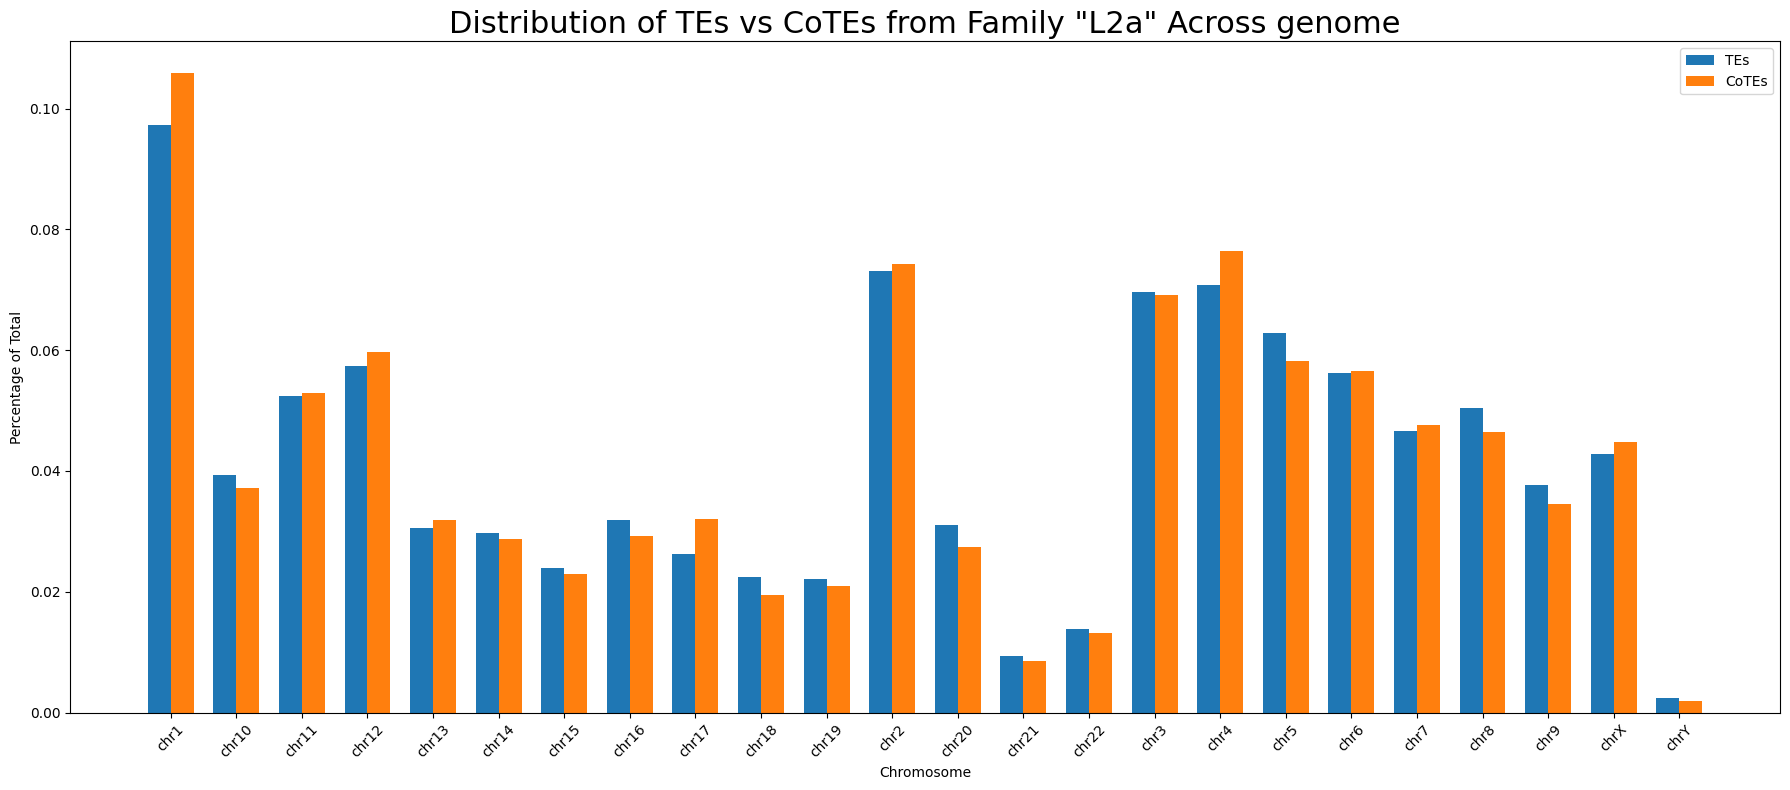

In [53]:
family = 'L2a'
fig=plot_te_family_distribution(__tes, __ctes, family)
fig.savefig(f'{family}.png')

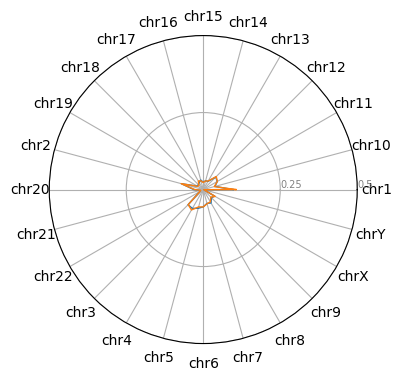

In [193]:
family = 'L2a'
fig=plot_te_family_radar(__tes, __ctes, [family] , 2)
fig.savefig(f'{family}_radar.png')

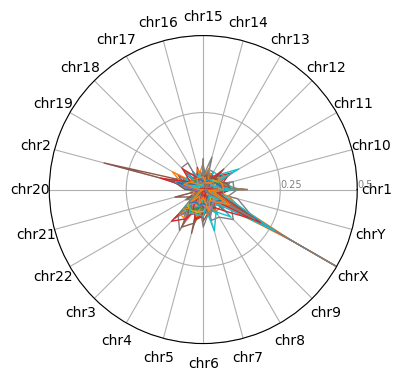

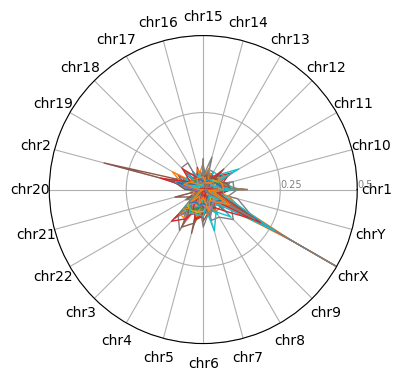

In [202]:
plot_te_family_radar(__tes, __ctes, te_df[te_df.Superfamily=='LINE1'].index , 2)

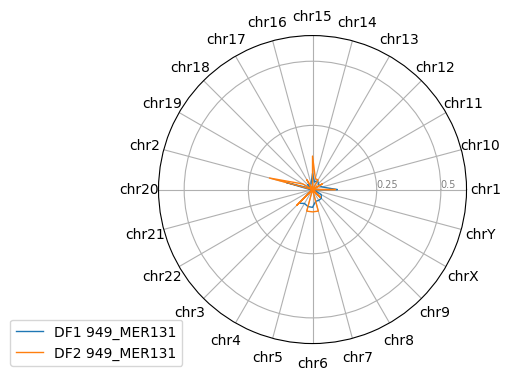

In [164]:
plot_te_family_radar(__tes, __ctes, te_df[te_df.Superfamily=='SINE'].index , 2)

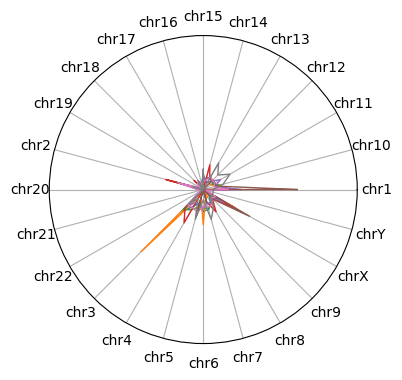

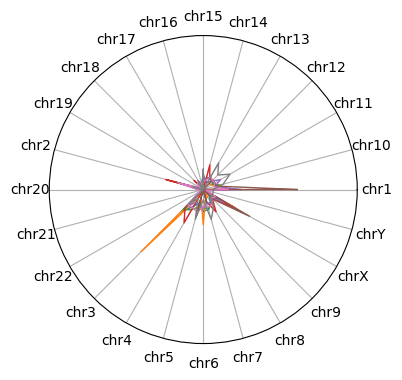

In [195]:
plot_te_family_radar(__tes, __ctes, te_df[te_df.Superfamily=='LINE'].index , 2, False)

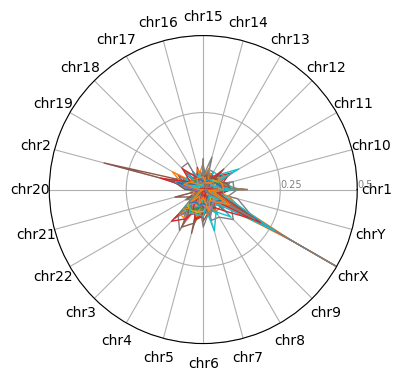

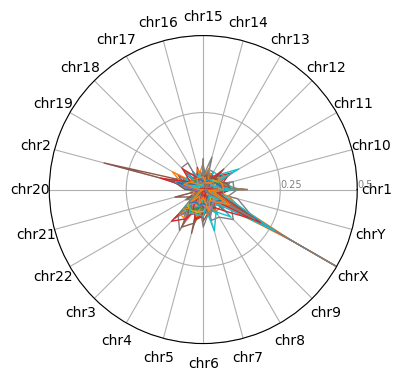

In [196]:
plot_te_family_radar(__tes, __ctes, te_df[te_df.Superfamily=='LINE1'].index , 2)

In [197]:
diff = df_t_percentage.reindex(df_ct_percentage.index) - df_ct_percentage

In [198]:
diff

,chr1,chr10,chr11,chr12,chr13,chr14,chr15,chr16,chr17,chr18,...,chr22,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chrX,chrY
Superfamily,,,,,,,,,,,,,,,,,,,,,
ERV1,0.666192,0.667984,-0.484982,-0.178162,0.723416,0.225940,-0.023333,-0.711034,-0.272682,0.394512,...,-0.356836,0.417576,0.857678,0.193760,0.341087,-0.467106,0.131338,0.094876,-1.402019,-0.061480
ERV3,0.009044,0.456178,0.334271,-0.713499,0.427085,-0.167400,0.466173,-0.957843,-0.147595,0.543908,...,-0.189489,0.111115,0.751160,0.179405,0.769083,0.385371,0.713797,0.194531,-1.267320,-0.275225
ERVL,1.182922,-0.774384,-0.661023,-0.594038,0.786897,0.236290,-0.006625,0.467427,-3.934487,0.511594,...,0.744939,2.582260,-0.949577,-1.773279,-2.777328,0.703717,-0.471108,0.333456,2.912771,0.016194
LINE,-1.080284,-0.496107,-0.964772,-0.093714,-1.052842,0.438595,0.177890,2.005450,0.666602,2.060821,...,1.046322,-6.176722,1.671954,0.866290,1.966232,0.321331,0.636532,0.623881,-4.425457,-0.598579
LINE1,-0.113428,0.258716,-0.004912,0.097119,0.405619,-0.060786,-0.385480,-0.029676,-0.274183,0.138064,...,-0.125178,0.245114,0.850516,0.180020,0.635320,-0.009219,0.376660,-0.337095,-1.727930,-0.273884
LINE2,-0.909267,0.282230,-0.152370,-0.378467,-0.063330,-0.054252,0.243634,0.117626,-0.545689,0.348285,...,-0.043001,0.408742,-0.210587,0.162004,0.080674,0.086755,0.222610,0.233279,-0.535886,0.056466
LINE3,-3.350987,-0.083605,-2.584916,-1.709990,0.302432,-0.305168,-0.427044,1.109356,-0.703741,-0.212867,...,0.134349,0.391742,2.559049,1.394685,1.341472,0.718360,1.083924,-0.933900,-0.303922,-0.078898
LINE4,-0.242167,0.853637,0.011387,-1.886143,-0.448561,-0.308783,1.417050,1.170221,-0.183710,0.926888,...,0.042319,0.900349,0.580179,-0.473486,-2.169912,-1.577987,0.320349,-0.931730,-0.013628,0.207111
LTR (no ERVs),2.286625,-0.237318,0.395510,-0.481121,0.251786,0.830935,-0.794660,-0.989984,-0.832526,0.978116,...,0.341006,-0.291792,1.230483,-0.063344,1.017267,1.155210,-0.617566,-0.217927,-0.864030,0.203979


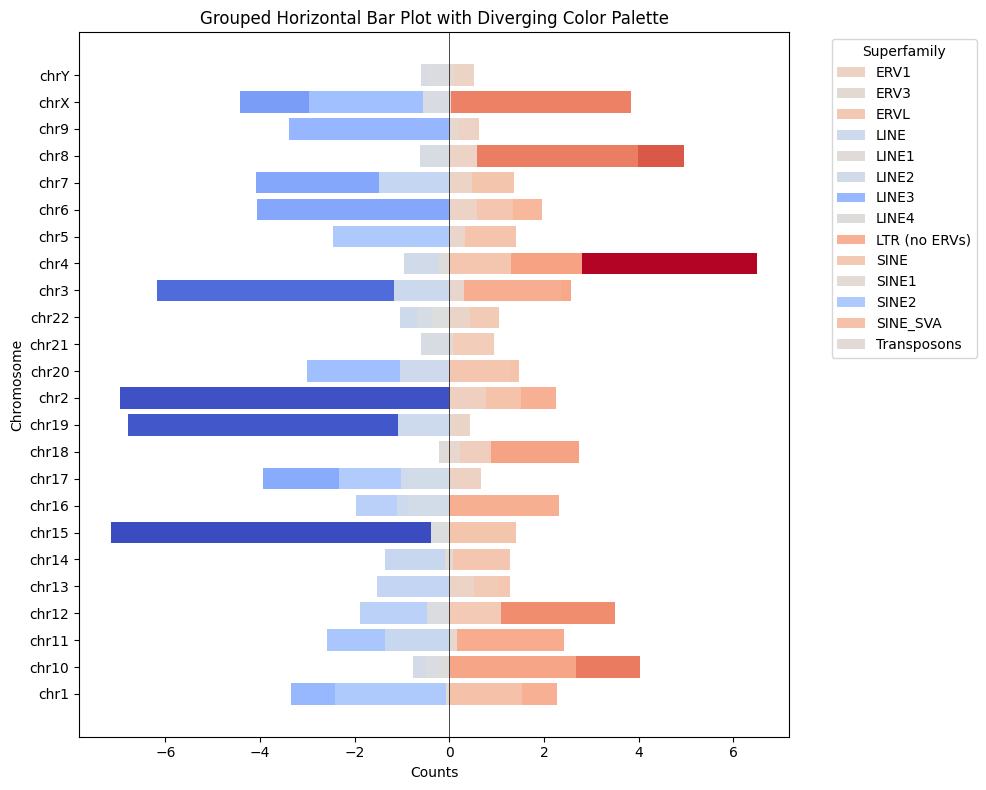

In [51]:
# Reset the index so that Superfamily becomes a column, then melt the DataFrame to long-form
df_reset = diff.reset_index()
df_long = df_reset.melt(id_vars='Superfamily', var_name='Chromosome', value_name='Counts')

# Define a function to map the values to colors
def value_to_color(val):
    norm = mcolors.Normalize(vmin=df_long['Counts'].min(), vmax=df_long['Counts'].max())
    cmap = plt.get_cmap('coolwarm')
    return cmap(norm(val))

# Create the bar plot
plt.figure(figsize=(10, 8))
for superfamily in df_long['Superfamily'].unique():
    subset = df_long[df_long['Superfamily'] == superfamily]
    plt.barh(subset['Chromosome'], subset['Counts'], color=subset['Counts'].apply(value_to_color), label=superfamily)

# Set labels and title
plt.xlabel('Counts')
plt.ylabel('Chromosome')
plt.title('Grouped Horizontal Bar Plot with Diverging Color Palette')

# Display the plot
plt.legend(title='Superfamily', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axvline(0, color='black', linewidth=0.5)  # Add zero line
plt.tight_layout()
plt.show()


In [25]:
diff.to_csv('./diff.csv', index=False)

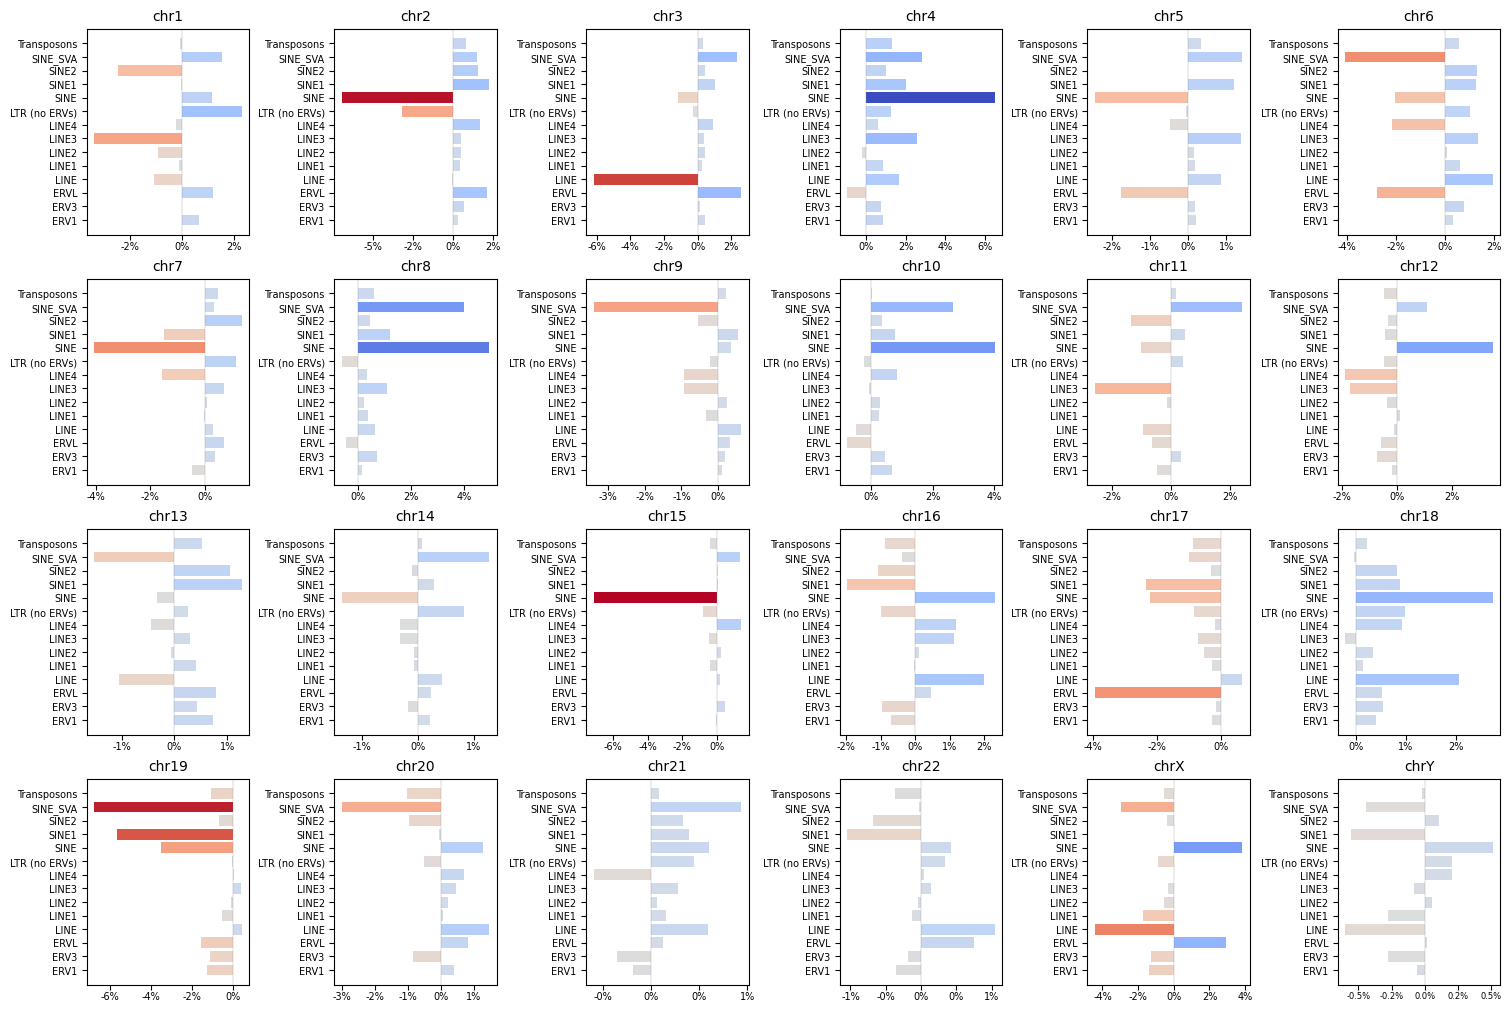

In [26]:
# Convert the DataFrame to long-form
df_long_new = diff.reset_index().melt(id_vars='Superfamily', var_name='Chromosome', value_name='Counts')

# Define a function to map the values to colors
def value_to_color(val):
    norm = mcolors.Normalize(vmin=df_long_new['Counts'].min(), vmax=df_long_new['Counts'].max())
    cmap = plt.get_cmap('coolwarm_r')
    return cmap(norm(val))

# Create a 4x6 grid of subplots
fig, axs = plt.subplots(4, 6, figsize=(15, 10), constrained_layout=True)

# Iterate over each chromosome and plot on separate ax
for ax, chromosome in zip(axs.ravel(), ca.info.CHROMOSOMES['names']):
    subset = df_long_new[df_long_new['Chromosome'] == chromosome]
    for category in subset['Superfamily'].unique():
        subsubset = subset[subset['Superfamily'] == category]
        ax.barh(subsubset['Superfamily'], subsubset['Counts'], color=subsubset['Counts'].apply(value_to_color))
    # Set title for each ax and adjust y-axis labels
    if chromosome=='chrY':
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1f}%'.format(x)))
        ax.tick_params(axis='x', labelsize=6, which='both', pad=1)
    else:
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))
        ax.tick_params(axis='x', labelsize=7, which='both', pad=1)
    ax.set_title(chromosome, fontsize=10)
    ax.set_yticks(subset['Superfamily'].unique())
    ax.set_yticklabels(subset['Superfamily'].unique(), fontsize=7)
    ax.grid(False)
    ax.axvline(0, color='grey', linewidth=0.2)  # Add zero line
# Set a global title for the entire figure
# fig.suptitle('Grouped Horizontal Bar Plot with Diverging Color Palette per Chromosome', fontsize=16)
plt.show()
fig.savefig('figure1-B.png')

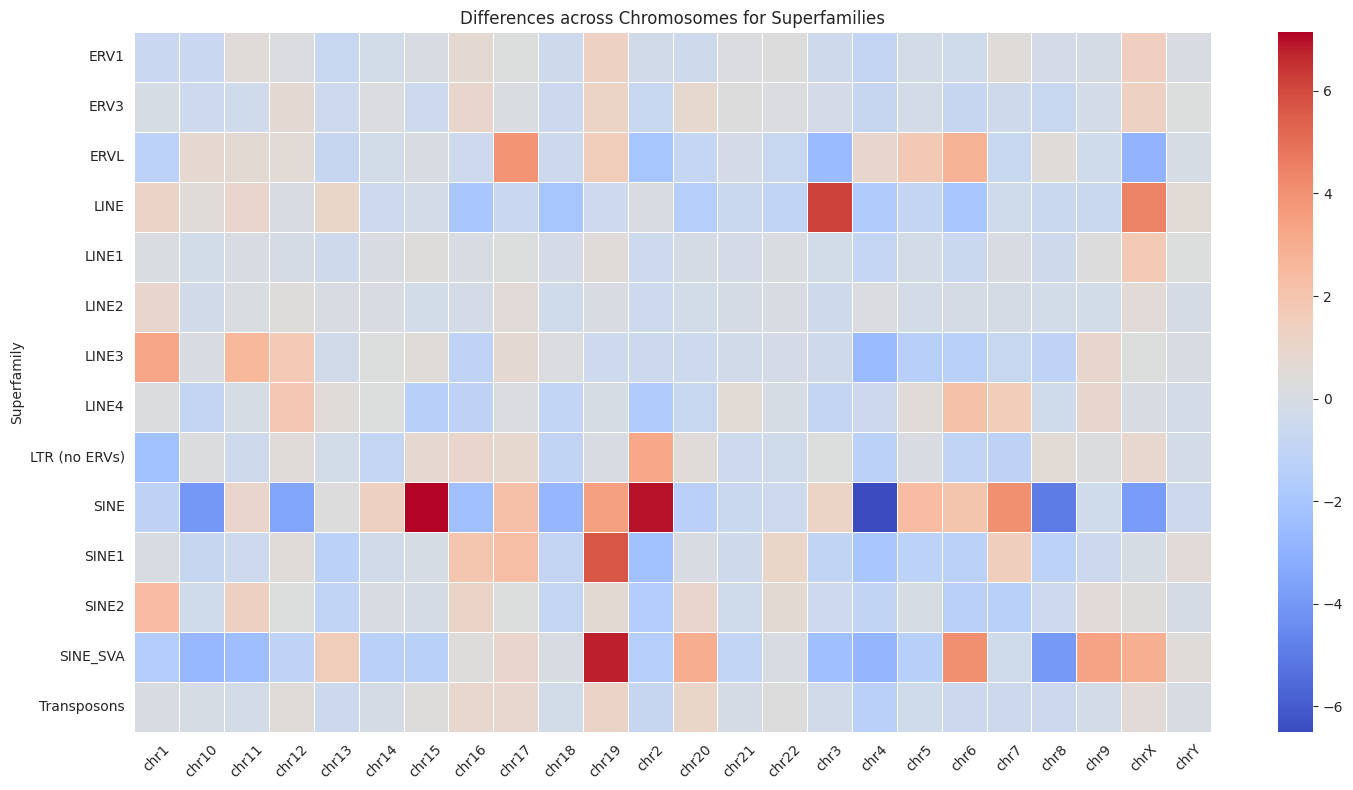

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

# Remove the index column
# diff.drop(columns=["Unnamed: 0"], inplace=True)

# Set the Superfamily as index for the heatmap
df_heatmap = diff.set_index('Superfamily')

# Draw the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(df_heatmap, cmap="coolwarm", annot=False, fmt=".2f", linewidths=.5)
plt.title("Differences across Chromosomes for Superfamilies")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [120]:
cols_with_te_elements = [col for col in te_df.columns if 'TE_Clusters' in col]
for col in cols_with_te_elements:
    te_df[col] = te_df[col] / te_df['n_clusters']

In [187]:
te_df.fillna(0, inplace=True)

In [9]:
te_df
te_df['overlapping_genes']= None
te_df['nearest_gene_before'] = None
te_df['nearest_gene_after'] = None

In [43]:
means = te_df.groupby(by='Superfamily').mean('n_clusters').drop(['COTE'], axis=1)

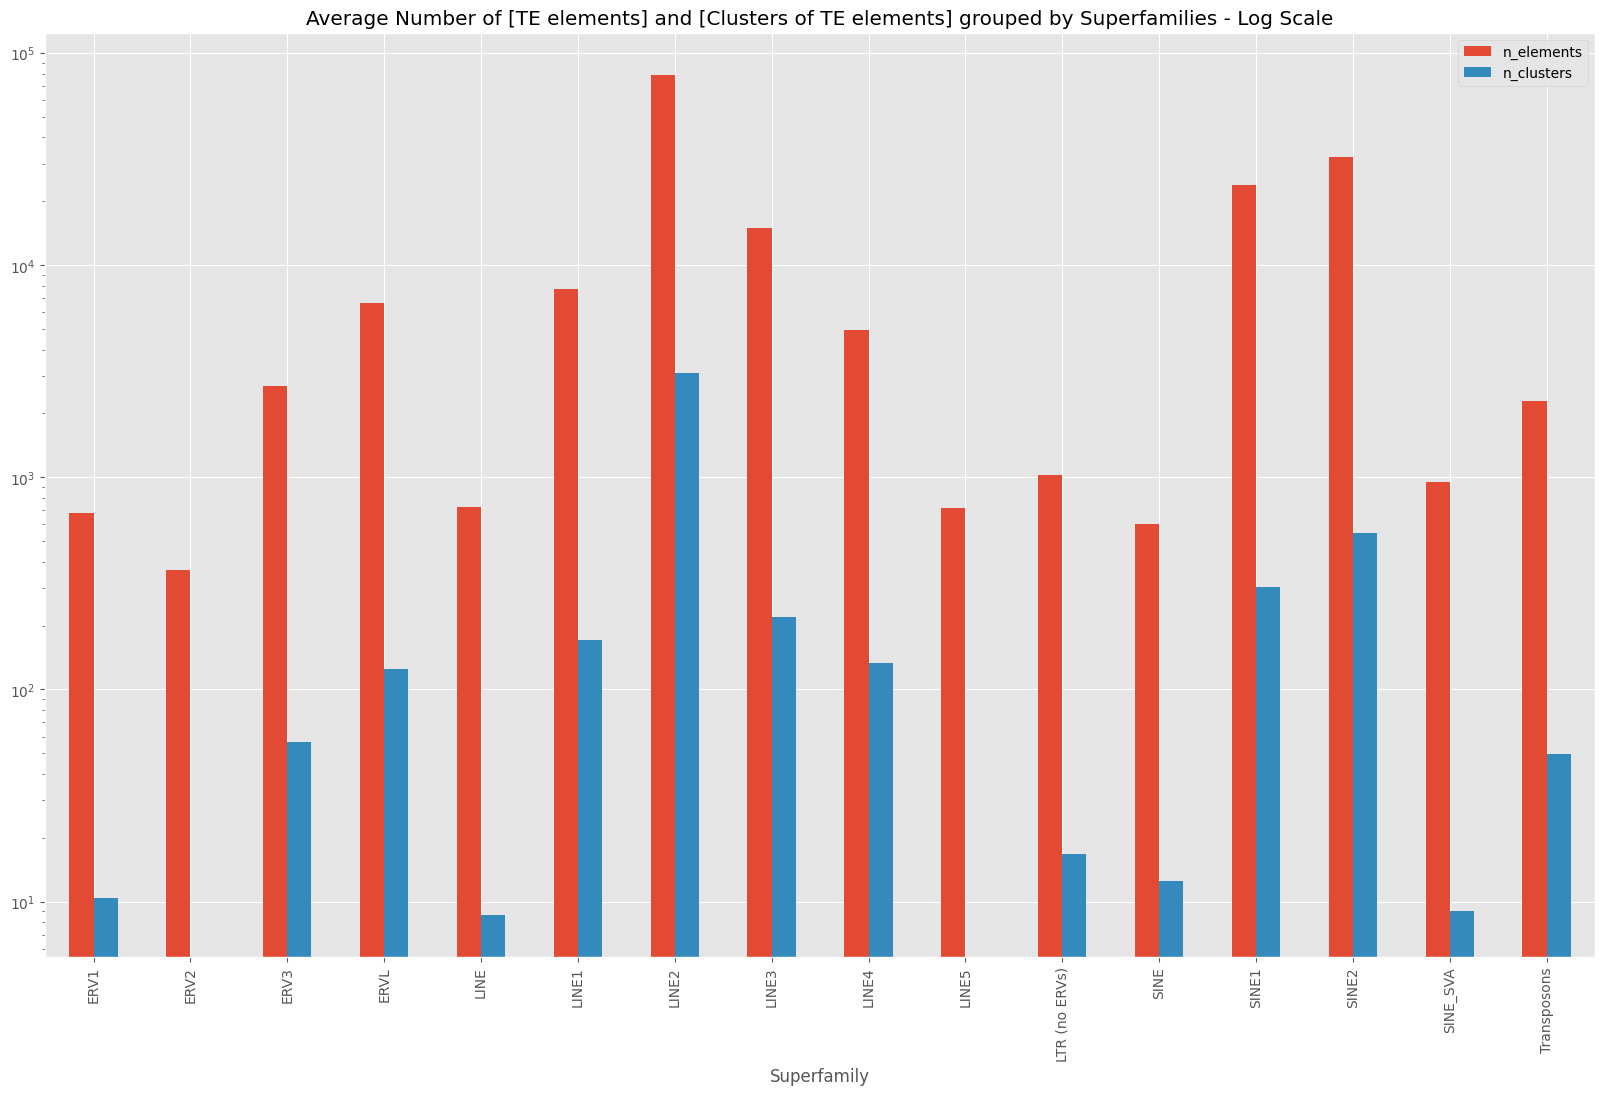

In [28]:
fig, axs = plt.subplots(figsize=(20, 12))
means.plot(kind='bar', logy=True, ax=axs)
plt.title('Average Number of [TE elements] and [Clusters of TE elements] grouped by Superfamilies - Log Scale')
fig.savefig('./mean_n_elements.png',  bbox_inches='tight')